# Small population SSI


In [4]:
import numpy as np
np.seterr('warn')

import matplotlib.pyplot as plt
import scipy.integrate as integrate
from tqdm import tqdm_notebook as tqdm
import math
import time
from scipy.stats import poisson
from scipy.stats import nbinom
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import poisson
from itertools import product

### Functions to compute SSI of small population of neurons ###

# granularity for simulation
n_step = 1
theta_step = 2 # > 1 to reduce computing time

# range of value for theta and n
n_range = np.arange(0,150,n_step) 
theta_range = np.arange(0,360,theta_step)

# theta follows a uniform distribution
p_theta = 1/len(theta_range)

# time bin of spike count
time_bin = 0.3

# baseline value of the tuning curve
b = 0.05

# amplitude of the tuning curve in Hz
f0 = 65/0.3

# standard deviation of the tuning curve in °
sigma_f=20

#tuning curve, bell-shaped with a baseline
def f(theta,theta_0,bl,s,n0):
    if theta_0 > 180 :
        if theta >= theta_0-180:
            return n0*((1-bl)*np.exp(-(theta-theta_0)**2 / (2 * s**2)) +bl)/0.3
        else :
            return n0*((1-bl)*np.exp(-(theta-theta_0+360)**2 / (2 * s**2)) +bl)/0.3
    else :
        if theta <= theta_0+180:
            return n0*((1-bl)*np.exp(-(theta-theta_0)**2 / (2 * s**2)) +bl)/0.3
        else :
            return n0*((1-bl)*np.exp(-(theta-theta_0-360)**2 / (2 * s**2)) +bl)/0.3


#correlation coefficients between 90° and 180° distant neurons
C_pi_2,C_pi = 0,0

# example quadruplet parameters value :
# thetas=[0,90,180,270],bs=[0.02,0.09,0.03,0.07],sgs=[40,42,43,43],n0s=[46,36,68,21]

### initiation function to specify number of neurons, their tuning curves and correlation ###

def initiate(nb = 4,correlated=False,thetas=[0,90,180,270],bs=[0.05,0.05,0.05,0.05],sgs=[42,42,42,42],n0s=[43,43,43,43]):
    
    # correlation can easily be made stimuli-dependent by changing the 2 rexpressions below
    stim_corr_90 = np.ones(len(theta_range))*C_pi_2
    stim_corr_180 = np.ones(len(theta_range))*C_pi

    ones = np.ones(len(theta_range))
    
    cov_matrixs = [[ones,stim_corr_90,stim_corr_180,stim_corr_90],
                  [stim_corr_90,ones,stim_corr_90,stim_corr_180],
                  [stim_corr_180,stim_corr_90,ones,stim_corr_90],
                  [stim_corr_90,stim_corr_180,stim_corr_90,ones]]
    
    cov_matrixs = np.transpose(cov_matrixs,axes=(2,0,1))
    
    # we store the multivariate distribution objet for faster computing
    p_r_theta_vect = []
    
    for i_theta in range(len(theta_range)):

        if correlated : 
            cov_matrix = cov_matrixs[i_theta]
        else :
            cov_matrix = np.identity(nb)
            
        p = multivariate_normal(mean=[f(theta_range[i_theta],thetas[i],bs[i],sgs[i],n0s[i])*time_bin for i in range(nb)], cov=np.array(cov_matrix))
        p_r_theta_vect.append(p)
        
    return(nb,thetas,bs,sgs,n0s,cov_matrix,p_r_theta_vect)


util_entropy = lambda t: t*np.log(t+10**-10)
vutil_entropy = np.vectorize(util_entropy)
    
def spec_inf(r_vects):
    
    H_theta = -np.log(p_theta)*np.ones(len(r_vects))
    H_theta_rs = np.zeros(len(r_vects))
    p_r_theta_vect_vals = []
    
    for i_theta in range(len(theta_range)):
        p_r_theta_vect_vals.append(p_r_theta_vect[i_theta].pdf(r_vects))

    p_r_theta_vect_vals = np.array(p_r_theta_vect_vals)

    for i_theta in range(len(theta_range)):
        p_theta_rs = np.divide( p_r_theta_vect_vals[i_theta], np.sum(p_r_theta_vect_vals,axis=0) )
        H_theta_rs = H_theta_rs - vutil_entropy(p_theta_rs)
    
    return(H_theta-H_theta_rs)    
    
# SSI computation using sampling
def SSI(i_theta):
    n_samples = 1000
    ssi = 0
    normal_samples = p_r_theta_vect[i_theta].rvs(size=n_samples).transpose()
    uniform_samples = [ norm(f(theta_range[i_theta],thetas[i],bs[i],sgs[i],n0s[i])*time_bin).cdf(normal_samples[i]) for i in range(NB_NEURONS) ]
    poisson_samples = [ poisson(f(theta_range[i_theta],thetas[i],bs[i],sgs[i],n0s[i])*time_bin).ppf(uniform_samples[i]) for i in range(NB_NEURONS) ]
    r_vects = np.array(poisson_samples).transpose()
    #print(np.corrcoef(poisson_samples[0],poisson_samples[1]))
    ssi = np.mean([x for x in spec_inf(r_vects) if ~np.isnan(x)])
    return(ssi)

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

#compute the correlation matrix from 10000 samples of the responses joint probability
def empirical_corr(i_theta,n_samples=10000):
    normal_samples = p_r_theta_vect[i_theta].rvs(size=n_samples).transpose()
    uniform_samples = [ norm(f(theta_range[i_theta],thetas[i],bs[i],sgs[i],n0s[i])*time_bin).cdf(normal_samples[i]) for i in range(NB_NEURONS) ]
    poisson_samples = [ poisson(f(theta_range[i_theta],thetas[i],bs[i],sgs[i],n0s[i])*time_bin).ppf(uniform_samples[i]) for i in range(NB_NEURONS) ]
    r_vects = np.array(poisson_samples).transpose()
    cov = np.cov(poisson_samples)
    return(correlation_from_covariance(cov))


np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [5]:
### function to compute single neuron SSI (don't requiere sampling) ###

def p_n_theta_1n(n_list,theta,theta_0,b,sg,n0):
    return(poisson(f(theta,theta_0,b,sg,n0)*time_bin).pmf(n_list))

#  joint density probability p(r|theta), computed for a list of theta
def p_n_theta_1_1n(n,theta_list):
    lambdas = [f(theta,theta_0,b,sg,n0)*time_bin for theta in theta_list]
    l = np.exp(sub_model.theta(lambdas)*n +gamma*(n**2) -sub_model.logZed(lambdas) - scipy.special.gammaln(n+1))
    return(l)
    
# create a look-up table containing all P(r|theta) = p(r|theta)/Z avec Z = sum_{r}p(r|theta)
def compute_lookup_table_1n(theta_0,b,sg,n0):
    P_mat = np.zeros((len(n_range),len(theta_range)))
    for j in range(len(theta_range)):
        P_mat[:,j] = p_n_theta_1n(n_range,theta_range[j],theta_0,b,sg,n0)
        P_mat[:,j] *= p_theta/np.sum(P_mat[:,j])
    return(P_mat)

# compute the specific information of a response given its index 
# in the discret range of possible response
def spec_inf_1n(lookup_table,i_n):
    entropy = -p_theta*np.log2(p_theta)*len(theta_range)
    cond_entropy = 0
    Z = [ lookup_table[i_n,i_theta] for i_theta in range(len(theta_range))] 
    p_n = sum(Z)/len(theta_range)
    for i_theta in range(len(theta_range)):
        p_t_n = lookup_table[i_n,i_theta]*p_theta/p_n
        cond_entropy += -p_t_n*np.log2(p_t_n+10**(-100))  
    return(entropy-cond_entropy)

def SSI_1n(P_mat,spec_infs,i_theta):
    SSI = 0
    for i_n in range(0,len(n_range)):
        SSI += spec_infs[i_n]*P_mat[i_n,i_theta]/p_theta
    return(SSI)


def return_SSI_1n(theta_0,b,sg,n0):
    P_matrix = compute_lookup_table_1n(theta_0,b,sg,n0)
    spec_infs = []
    for i_n in  range(len(n_range)) :
        spec_infs.append(spec_inf_1n(P_matrix,i_n))
    SSI_1= []
    for theta in range(len(theta_range)):
        SSI_1.append(SSI_1n(P_matrix,spec_infs,theta))
    return(SSI_1)


## Study of stimuli-dependent correlation between 4 neurons

In [7]:
# We compute the SSI for 4 neurons population with no correlation and with measured correlation

global_SSI_corr = []
alphas = [0,1]
for a in alphas :
    
    # instantiate correlation values
    C_pi_2,C_pi = 0.22*a,0.15*a
    
    # initiate the model
    NB_NEURONS,thetas,bs,sgs,n0s,cov_matrix,p_r_theta_vect = initiate(4,correlated=True)

    #check that we have the intended correlation
    #print(empirical_corr(0))

    global_SSI_corr_temp = []
    for i in tqdm(range(len(theta_range))):
        global_SSI_corr_temp.append(SSI(i))
    global_SSI_corr.append(global_SSI_corr_temp)


C:\Users\fphub\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:109: RuntimeWarning: underflow encountered in true_divide
C:\Users\fphub\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:94: RuntimeWarning: underflow encountered in double_scalars


<IPython.core.display.Javascript object>


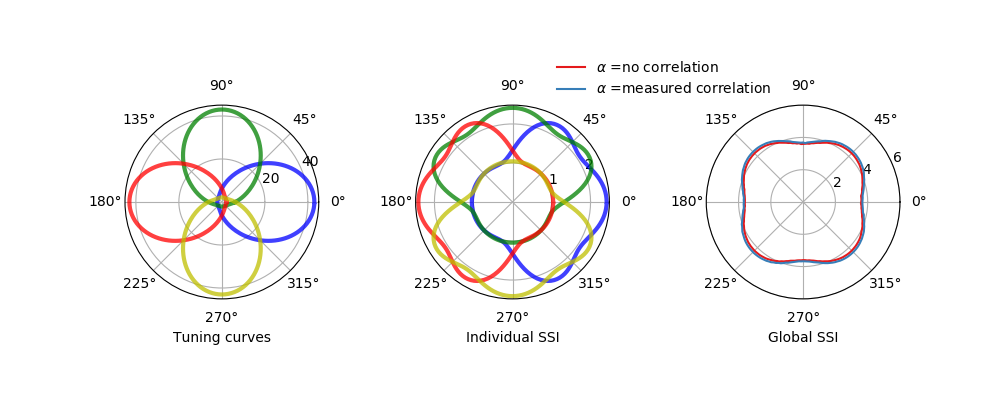

In [20]:
%matplotlib notebook
import brewer2mpl
bmap = brewer2mpl.get_map('Set1', 'qualitative', 5)
colors = bmap.mpl_colors
colors_c = ['b','g','r','y']


fig,axs = plt.subplots(1,3,figsize=(10,4),subplot_kw=dict(polar=True))

thetas=[0,90,180,270]
bs=[0.05,0.05,0.05,0.05]
sgs=[42,42,42,42]
n0s=[43,43,43,43]

# plotting the tuning cruves
SSI_single = []
for i in range(NB_NEURONS):
    axs[0].plot(np.radians(theta_range),[f(theta,thetas[i],bs[i],sgs[i],n0s[i])*0.3 for theta in theta_range],color=colors_c[i], linewidth=3,alpha=0.75)
    SSI_single.append(return_SSI_1n(thetas[i],bs[i],sgs[i],n0s[i]))

# plotting the individual SSI
for i in range(NB_NEURONS) :
    axs[1].plot(np.radians(theta_range),SSI_single[i],color=colors_c[i], linewidth=3,alpha=0.75)

# plotting the population SSI   
colors_ssi = plt.cm.viridis(np.linspace(0,1,len(global_SSI_corr)))
legends=["no correlation","measured correlation"]
for i in range(len(global_SSI_corr)):
    axs[2].plot(np.radians(theta_range),global_SSI_corr[i],color=colors[i], linewidth=1.5,label=r"$\alpha$ ="+str(legends[i]))

axs[2].legend(bbox_to_anchor=(0.4, 1.3),frameon=False)

axs[0].yaxis.get_major_locator().base.set_params(nbins=4)
axs[1].yaxis.get_major_locator().base.set_params(nbins=4)
axs[2].yaxis.get_major_locator().base.set_params(nbins=4)

axs[0].set_xlabel("Tuning curves")
axs[1].set_xlabel("Individual SSI")
axs[2].set_xlabel("Global SSI")

axs[2].set_ylim(top=6)
fig.subplots_adjust(wspace=0.5)
plt.show()

We can see that fixed correlation coefficients don't amount to striclty stimuli-independent correlations due to copula settings


C_pi_2 = 0.22
C_pi = 0.15


<IPython.core.display.Javascript object>


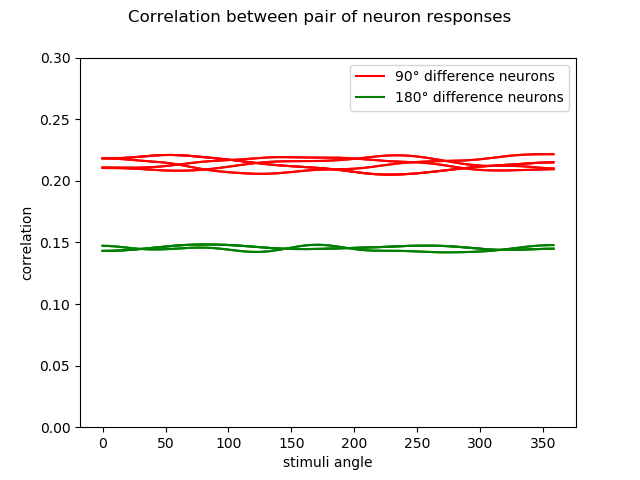

In [30]:
%matplotlib notebook

# computing empirical correlation between 4 neuron response

l=[]
for i in tqdm(range(len(theta_range))) :
    l.append(empirical_corr(i))

    
color = ['r','g']
labels=['90° difference neurons','180° difference neurons']

print('C_pi_2 =',C_pi_2)
print('C_pi =',C_pi)



from scipy.ndimage import gaussian_filter1d

for i in range(len(l[0])):
    for j in range(len(l[0][0])):
        if np.abs(i-j) == 2 :
            plt.plot(theta_range,gaussian_filter1d([l[t][i][j] for t in range(len(l))],10),color=color[1])
        elif i != j :
            plt.plot(theta_range,gaussian_filter1d([l[t][i][j] for t in range(len(l))],10),color=color[0])
        
        if i == 0 and j == 1 :
            plt.plot(theta_range,gaussian_filter1d([l[t][i][j] for t in range(len(l))],10),label=labels[0],color=color[0])
        if i == 0 and j == 2 : 
            plt.plot(theta_range,gaussian_filter1d([l[t][i][j] for t in range(len(l))],10),label=labels[1],color=color[1])

plt.ylim(0,0.3)
plt.legend()
plt.suptitle("Correlation between pair of neuron responses")
plt.xlabel("stimuli angle")
plt.ylabel("correlation")
plt.show()